In [1]:
import timm
import torch
import torch.nn as nn
from collections import OrderedDict
import re
import numpy as np
from torchsummary import summary
from collections import defaultdict, OrderedDict
import ipdb
import torch.nn.functional as F
from collections import defaultdict, OrderedDict

import numpy as np
import torch
from torch import nn
from torch.optim import *
from torch.optim.lr_scheduler import *
from torch.utils.data import DataLoader
from torchvision.datasets import *
from torchvision.transforms import *
import torch.optim as optim


from collections import defaultdict, OrderedDict

import copy
import numpy as np
import torch
from torch import nn
from torch.optim import *
from torch.optim.lr_scheduler import *
from torch.utils.data import DataLoader
from torchvision.datasets import *
from torchvision.transforms import *
import torch.optim as optim

from collections import defaultdict, OrderedDict

import copy
import numpy as np
import torch
from torch import nn
from torch.optim import *
from torch.optim.lr_scheduler import *
from torch.utils.data import DataLoader
from torchvision.datasets import *
from torchvision.transforms import *
import torch.optim as optim


/home/sathya/anaconda3/lib/python3.11/site-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


In [2]:
image_size = 32
transforms = {
    "train": Compose([
        RandomCrop(image_size, padding=4),
        RandomHorizontalFlip(),
        ToTensor(),
    ]),
    "test": ToTensor(),
}
dataset = {}
for split in ["train", "test"]:
  dataset[split] = CIFAR10(
    root="data/cifar10",
    train=(split == "train"),
    download=True,
    transform=transforms[split],
  )
dataloader = {}
for split in ['train', 'test']:
  dataloader[split] = DataLoader(
    dataset[split],
    batch_size=512,
    shuffle=(split == 'train'),
    num_workers=0,
    pin_memory=True,
  )

Files already downloaded and verified
Files already downloaded and verified


In [3]:

def name_fixer(names):
    """
    Fix the names by removing the indices in square brackets.
    Args:
      names (list): List of names.

    Returns:
      list: List of fixed names.
    """
    return_list = []
    for string in names:
        matches = re.finditer(r'\.\[(\d+)\]', string)
        pop_list = [m.start(0) for m in matches]
        pop_list.sort(reverse=True)
        if len(pop_list) > 0:
            string = list(string)
            for pop_id in pop_list:
                string.pop(pop_id)
            string = ''.join(string)
        return_list.append(string)
    return return_list


class VGG(nn.Module):
    ARCH = [64, 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M']

    def __init__(self) -> None:
        super().__init__()

        layers = []
        counts = defaultdict(int)

        def add(name: str, layer: nn.Module) -> None:
            layers.append((f"{name}{counts[name]}", layer))
            counts[name] += 1

        in_channels = 3
        for x in self.ARCH:
            if x != 'M':
                # conv-bn-relu
                add("conv", nn.Conv2d(in_channels, x, 3, padding=1, bias=False))
                add("bn", nn.BatchNorm2d(x))
                add("relu", nn.ReLU(True))
                in_channels = x
            else:
                # maxpool
                add("pool", nn.MaxPool2d(2))

        self.backbone = nn.Sequential(OrderedDict(layers))
        self.classifier = nn.Linear(512, 10)

    def forward(self, x: torch.Tensor) -> torch.Tensor:

        # backbone: [N, 3, 32, 32] => [N, 512, 2, 2]
        x = self.backbone(x)

        # avgpool: [N, 512, 2, 2] => [N, 512]
        x = x.mean([2, 3])

        # classifier: [N, 512] => [N, 10]
        x = self.classifier(x)
        return x


fusing_layers = [
    'Conv2d',
    'BatchNorm2d',
    'ReLU',
    'Linear',
    'BatchNorm1d',
]

import copy


def get_all_layers(model, parent_name=''):
    layers = []
    for name, module in model.named_children():
        full_name = f"{parent_name}.{name}" if parent_name else name
        test_name = "model." + full_name
        try:
            eval(test_name)
            layers.append((full_name, module))
        except:
            layers.append((reformat_layer_name(full_name), module))
        if isinstance(module, nn.Module):
            layers.extend(get_all_layers(module, parent_name=full_name))
    return layers


def reformat_layer_name(str_data):
    try:
        split_data = str_data.split('.')
        for ind in range(len(split_data)):
            data = split_data[ind]
            if (data.isdigit()):
                split_data[ind] = "[" + data + "]"
        final_string = '.'.join(split_data)

        iters_a = re.finditer(r'[a-zA-Z]\.\[', final_string)
        indices = [m.start(0) + 1 for m in iters_a]
        iters = re.finditer(r'\]\.\[', final_string)
        indices.extend([m.start(0) + 1 for m in iters])

        final_string = list(final_string)
        final_string = [final_string[i] for i in range(len(final_string)) if i not in indices]

        str_data = ''.join(final_string)

    except:
        pass

    return str_data


def summary_string_fixed(model, all_layers, input_size, model_name=None, batch_size=-1, dtypes=None):
    if dtypes is None:
        dtypes = [torch.FloatTensor] * len(input_size)

    def register_hook(module, module_idx):
        def hook(module, input, output):
            nonlocal module_idx
            m_key = all_layers[module_idx][0]
            m_key = model_name + "." + m_key

            try:
                eval(m_key)
            except:
                m_key = name_fixer([m_key])[0]

            summary[m_key] = OrderedDict()
            summary[m_key]["type"] = str(type(module)).split('.')[-1][:-2]
            summary[m_key]["x"] = input
            summary[m_key]["input_shape"] = list(input[0].size())
            summary[m_key]["input_shape"][0] = batch_size

            if isinstance(output, (list, tuple)):
                summary[m_key]["y"] = [
                    [-1] + list(o)[1:] for o in output
                ]
                summary[m_key]["output_shape"] = [
                    [-1] + list(o.size())[1:] for o in output
                ]
            else:
                summary[m_key]["y"] = list(output)


                summary[m_key]["output_shape"] = list(output.size())
                summary[m_key]["output_shape"][0] = batch_size

            params = 0
            if hasattr(module, "weight") and hasattr(module.weight, "size"):
                summary[m_key]["w"] = module.weight
                params += torch.prod(torch.LongTensor(list(module.weight.size())))
                summary[m_key]["trainable"] = module.weight.requires_grad
                summary[m_key]["weight_shape"] = module.weight.shape
            if hasattr(module, "bias") and hasattr(module.bias, "size"):
                summary[m_key]["b"] = module.bias
                params += torch.prod(torch.LongTensor(list(module.bias.size())))
            summary[m_key]["nb_params"] = params

        if (
                not isinstance(module, nn.Sequential)
                and not isinstance(module, nn.ModuleList)
        ):
            hooks.append(module.register_forward_hook(hook))

    if isinstance(input_size, tuple):
        input_size = [input_size]
        
    model_device = next(iter(model.parameters())).device
    x, _ = next(iter(dataloader['test']))
    x = x.to(model_device)

    summary = OrderedDict()
    hooks = []

    for module_idx, (layer_name, module) in enumerate(all_layers):
        register_hook(module, module_idx)

    model(x)

    for h in hooks:
        h.remove()

    return summary


def get_input_channel_importance(weight):
    importances = []
    for i_c in range(weight.shape[1]):
        channel_weight = weight.detach()[:, i_c]
        importance = torch.norm(channel_weight)
        importances.append(importance.view(1))
    return torch.cat(importances)


def get_importance(layer, sparsity):
    sorted_indices = torch.argsort(get_input_channel_importance(layer.weight), descending=True)
    n_keep = int(round(len(sorted_indices) * (1.0 - sparsity)))
    indices_to_keep = sorted_indices[:n_keep]
    return indices_to_keep




import copy


@torch.no_grad()
def prune_cwp(model, pruning_ratio_list):
    
    pruned_model = copy.deepcopy(model)
    

    def get_layer_name(obj):
        if isinstance(obj, list):
            layer_list = []
            for internal_layer in obj:
                layer_list.append(eval(internal_layer.replace('model', 'pruned_model')))
            return layer_list
        else:
            nonlocal pruned_model
            return eval(obj.replace('model', 'pruned_model'))

    for list_ind in range(len(possible_indices_ranges)):
        sparsity = pruning_ratio_list[list_ind]
        layer_list = np.asarray(possible_indices_ranges[list_ind])

        prev_conv = get_layer_name(layer_list[0, 0])
        prev_bn = get_layer_name(layer_list[0, 1])
        next_convs = [c for c in get_layer_name(list(layer_list[1:, 0]))]
        next_bns = [b for b in get_layer_name(list(layer_list[1:-1, 1]))]  # Avoid last 0

        if (len(next_bns) == 0):
            iter_layers = zip([prev_conv, prev_bn], [next_convs, []])
        else:
            iter_layers = zip([prev_conv, prev_bn], [next_convs, next_bns])

        importance_list_indices = get_importance(layer=next_convs[-1], sparsity=sparsity)

        def prune_bn(layer, importance_list_indices):

            layer.weight.set_(layer.weight.detach()[importance_list_indices])
            layer.bias.set_(layer.bias.detach()[importance_list_indices])
            layer.running_mean.set_(layer.running_mean.detach()[importance_list_indices])
            layer.running_var.set_(layer.running_var.detach()[importance_list_indices])

        for prev_layer, next_layers in iter_layers:
            if(prev_layer != 0): #No BatchNorm Used:
                
                if (str(type(prev_layer)).split('.')[-1][:-2] == 'BatchNorm2d'):  # BatchNorm2d
                    prune_bn(prev_layer, importance_list_indices)
                else:
                    prev_layer.weight.set_(prev_conv.weight.detach()[importance_list_indices, :])
                    if prev_layer.bias is not None:
                                bias_shape = prev_layer.weight.shape[0]
                                prev_layer.bias = nn.Parameter(prev_layer.bias[:bias_shape])
                    

            if (len(next_layers) != 0):
                for next_layer in next_layers:
                    if (str(type(next_layer)).split('.')[-1][:-2] == 'BatchNorm2d'):  # BatchNorm2d
                        prune_bn(next_layer, importance_list_indices)
                    else:
                        if (next_layer.weight.shape[1] == 1):
                            

                            next_layer.weight.set_(next_layer.weight.detach()[importance_list_indices, :])
                            number_of_channels = len(importance_list_indices)
                            next_layer.groups = number_of_channels
                           
                            if next_layer.bias is not None:
                                bias_shape = next_layer.weight.shape[0]
                                next_layer.bias = nn.Parameter(next_layer.bias[:bias_shape])
     
                              
                        else:
                            
                            next_layer.weight.set_(next_layer.weight.detach()[:, importance_list_indices])
#                             next_layer.groups = len(importance_list_indices)
                            if next_layer.bias is not None:
                                bias_shape = next_layer.weight.shape[0]
                                next_layer.bias = nn.Parameter(next_layer.bias[:bias_shape])
                
#                             if(next_layer.bias!=None):
#                                 next_layer.bias.set_(next_layer.bias[:next_layer.weight.shape[1]])
#                                 print(len(next_layer.bias))

    return pruned_model, model


def layer_mapping(model):
    all_layers = get_all_layers(model)
    x,y = next(iter(dataloader['test']))
    model_summary = summary_string_fixed(model, all_layers, x.shape, model_name='model')  # , device="cuda")

    name_type_shape = []
    for key in model_summary.keys():
        data = model_summary[key]
        if ("weight_shape" in data.keys()):
            name_type_shape.append([key, data['type'], data['weight_shape'][0]])
        else:
            name_type_shape.append([key, data['type'], 0 ])
    name_type_shape = np.asarray(name_type_shape)

    name_list = name_type_shape[:, 0]

    r_name_list = np.asarray(name_list)
    random_picks = np.random.randint(0, len(r_name_list), 10)
    test_name_list = r_name_list[random_picks]
    eval_hit = False
    for layer in test_name_list:
        try:
            eval(layer)

        except:
            eval_hit = True
            break
    if (eval_hit):
        fixed_name_list = name_fixer(r_name_list)
        name_type_shape[:, 0] = fixed_name_list

    layer_types = name_type_shape[:, 1]
    layer_shapes = name_type_shape[:, 2]
    mapped_layers = {'model_layer': [], 'Conv2d_BatchNorm2d_ReLU': [], 'Conv2d_BatchNorm2d': [], 'Linear_ReLU': [],
                     'Linear_BatchNorm1d': []}

    def detect_sequences(lst):
        i = 0
        while i < len(lst):

            if i + 2 < len(lst) and [l for l in lst[i: i + 3]] == [
                fusing_layers[0],
                fusing_layers[1],
                fusing_layers[2],
            ]:
                
#                 test_layer = layer_shapes[i: i + 2]
#                 if (np.all(test_layer == test_layer[0])):
                mapped_layers['Conv2d_BatchNorm2d_ReLU'].append(
                        np.take(name_list, [i for i in range(i, i + 3)]).tolist()
                    )
                i += 3

            elif i + 1 < len(lst) and [l for l in lst[i: i + 2]] == [
                fusing_layers[0],
                fusing_layers[1],
            ]:
#                 test_layer = layer_shapes[i: i + 2]
#                 if (np.all(test_layer == test_layer[0])):
                mapped_layers['Conv2d_BatchNorm2d'].append(
                        np.take(name_list, [i for i in range(i, i + 2)]).tolist()
                    )
                i += 2
            # if i + 1 < len(lst) and [ type(l) for l in lst[i:i+2]] == [fusing_layers[0], fusing_layers[2]]:
            #     detected_sequences.append(np.take(name_list,[i for i in range(i,i+2)]).tolist())
            #     i += 2
            # elif i + 1 < len(lst) and [ type(l) for l in lst[i:i+2]] == [fusing_layers[1], fusing_layers[2]]:
            #     detected_sequences.append(np.take(name_list,[i for i in range(i,i+2)]).tolist())
            #     i += 2
            elif i + 1 < len(lst) and [l for l in lst[i: i + 2]] == [
                fusing_layers[3],
                fusing_layers[2],
            ]:
                mapped_layers['Linear_ReLU'].append(
                    np.take(name_list, [i for i in range(i, i + 2)]).tolist()
                )
                i += 2
            elif i + 1 < len(lst) and [l for l in lst[i: i + 2]] == [
                fusing_layers[3],
                fusing_layers[4],
            ]:
                mapped_layers['Linear_BatchNorm1d'].append(
                    np.take(name_list, [i for i in range(i, i + 2)]).tolist()
                )
                i += 2
            else:
                i += 1

    detect_sequences(layer_types)

    for keys, value in mapped_layers.items():
        mapped_layers[keys] = np.asarray(mapped_layers[keys])

    mapped_layers['name_type_shape'] = name_type_shape
    # self.mapped_layers = mapped_layers

    # CWP
    keys_to_lookout = ['Conv2d_BatchNorm2d_ReLU', 'Conv2d_BatchNorm2d']
    pruning_layer_of_interest, qat_layer_of_interest = [], []

    # CWP or QAT Fusion Layers
    for keys in keys_to_lookout:
        data = mapped_layers[keys]
        if (len(data) != 0):
            qat_layer_of_interest.append(data)
    mapped_layers['qat_layers'] = qat_layer_of_interest
    mapped_layers['model_summary'] = model_summary

    name_list = mapped_layers['name_type_shape'][:, 0]
    layer_name_list = []
    w, x, y = [], [], []
    for layer_name in name_list:
        layer = eval(layer_name)
        if(isinstance(layer,(nn.Conv2d,nn.Linear))):
            layer_name_list.append(layer_name)
            x.append(mapped_layers['model_summary'][layer_name]['x'][0])
            w.append(mapped_layers['model_summary'][layer_name]['w'])
            y.append(torch.stack(mapped_layers['model_summary'][layer_name]['y']))
            # b.append(mapped_layers['model_summary'][layer_name]['b'])
     
    mapped_layers['catcher'] = {'name_list':layer_name_list, 'x':x,'w':w,'y':y}

    return mapped_layers


# GMP
#         layer_of_interest=mapped_layers['name_type_shape'][:,0] # all layers with weights
#         Check for all with weights
# Wanda

def string_fixer(name_list):
    for ind in range(len(name_list)):
        modified_string = re.sub(r'\.(\[)', r'\1', name_list[ind])
        name_list[ind] = modified_string



In [4]:
def cwp_possible_layers(layer_name_list):
    possible_indices = []
    idx = 0
    
    while idx < len(layer_name_list):
        current_value = layer_name_list[idx]
        layer_shape = eval(current_value).weight.shape
        curr_merge_list = []
        curr_merge_list.append([current_value, 0])
        hit_catch = False
        for internal_idx in range(idx + 1, len(layer_name_list) - 1):
            new_layer = layer_name_list[internal_idx]
            new_layer_shape = eval(new_layer).weight.shape
            if len(new_layer_shape) == 4:
                curr_merge_list.append([new_layer, 0])
                if layer_shape[0] == new_layer_shape[1]:
                    hit_catch = True
                    break
            elif len(new_layer_shape) == 1:
                curr_merge_list[len(curr_merge_list) - 1][1] = new_layer
        possible_indices.append(curr_merge_list)
        if hit_catch == True:
            idx = internal_idx
        else:
            idx += 1
    return possible_indices

def detect_sorting_pairs(name_list):
    sorting_pairs = []
    idx = 0
    while idx < len(name_list):
        layer_list = [ layer_name for layer_name in name_list[idx:idx+3]]
        
        if([ type(eval(l)) for l in layer_list] == [nn.Conv2d, nn.BatchNorm2d,nn.Conv2d]):
            sorting_pairs.append(layer_list)
            idx+=2
        elif([ type(eval(l)) for l in layer_list[idx:idx+2]] == [nn.Conv2d, nn.Conv2d]):
            sorting_pairs.append(layer_list[idx:idx+2].insert(1,0))
            idx+=1
        else:
            idx+=1
    return sorting_pairs


def detect_sorting_all_pairs(conv_bn_list):
    possible_list = []
    idx = 0
    start_idx = 0
    end_idx = len(conv_bn_list)
    while idx < len(conv_bn_list):
        first_layer = eval(conv_bn_list[idx])

        if(end_idx+1 - start_idx)<=2:
            break

        elif isinstance(first_layer, nn.Conv2d):
            first_layer_shape = first_layer.weight.shape[:2]
            start_idx = idx
            for end_idx in range(start_idx, len(conv_bn_list)):
                compare_layer = eval(conv_bn_list[end_idx])

                if isinstance(compare_layer, nn.Conv2d):
                    compare_layer_shape = compare_layer.weight.shape[:2]

                    if first_layer_shape[0] == compare_layer_shape[1]:
                        possible_list.append([eval(i) for i in conv_bn_list[start_idx:end_idx + 1]])
                        idx = end_idx
                        break

        else:  # BatchNorm case
            idx += 1
            
    return possible_list
    
    
# function to sort the channels from important to non-important
def get_input_channel_importance(weight):
    in_channels = weight.shape[0] if weight.shape[1]==1 else weight.shape[1]
    
    
    importances = []
    # compute the importance for each input channel
    for i_c in range(in_channels):
        if(weight.shape[1]==1):
          
            channel_weight = weight.detach()[ i_c,:]
        else:
            channel_weight = weight.detach()[:, i_c]
            

        importance = torch.norm(channel_weight)

        importances.append(importance.view(1))
    if(weight.shape[1]==1):
        return torch.cat(importances), 0
    else:
        return torch.cat(importances), 1

@torch.no_grad()
def apply_channel_sorting(model, layer_lists):
    model = copy.deepcopy(model)  # do not modify the original model
    
    for prev_conv, prev_bn, next_conv in layer_lists:
        #check prev_bn is conv or not
        if(prev_conv.weight.shape[1]!=1 and next_conv.weight.shape[1]!=1):
            importance, dimension = get_input_channel_importance(next_conv.weight)
            # sorting from large to small
            sort_idx = torch.argsort(importance, descending=True)

            # apply to previous conv and its following bn
            prev_conv.weight.copy_(torch.index_select(
                prev_conv.weight.detach(), 0, sort_idx))
            if(prev_bn!=0):
                for tensor_name in ['weight', 'bias', 'running_mean', 'running_var']:
                    tensor_to_apply = getattr(prev_bn, tensor_name)
                    tensor_to_apply.copy_(
                        torch.index_select(tensor_to_apply.detach(), 0, sort_idx)
                    )

            # apply to the next conv input (hint: one line of code)

            next_conv.weight.copy_(
                torch.index_select(next_conv.weight.detach(), 1, sort_idx))
#         else: #Depthwise Convs can be ignored for sorting
#             print("Ignore Layer for Sorting")

    ###############
    
#     for layer_list in layer_lists:
#         not_last_layers = layer_list[:-1]
#         last_layer = layer_list[-1]
#         importance, dimension = get_input_channel_importance(last_layer.weight)
#         sort_idx = torch.argsort(importance, descending=True)
        
#         #Conv Conv | Conv Bn Conv | Conv Bn Conv Bn Conv....Conv
        
#         for layer_idx in range(len(not_last_layers)):
#             layer = not_last_layers[layer_idx]     
            
#             if(layer_idx==0): #First Conv
#                 layer.weight.copy_(torch.index_select(layer.weight.detach(), 0, sort_idx))
                
#             elif(isinstance(layer,nn.Conv2d)): #Next Conv's
#                 if(layer.weight.shape[1]==1): #Group Convs
#                     continue
                        
# #                     layer.weight.copy_(torch.index_select(layer.weight.detach(), 0, sort_idx))
#                 else:
#                      layer.weight.copy_(torch.index_select(layer.weight.detach(), 1, sort_idx))
                    
#             elif(isinstance(layer,nn.BatchNorm2d)): #Next Bn's
#                 for tensor_name in ['weight', 'bias', 'running_mean', 'running_var']:
#                     tensor_to_apply = getattr(layer, tensor_name)
#                     tensor_to_apply.copy_(torch.index_select(tensor_to_apply.detach(), 0, sort_idx))
                

    return model


In [5]:
# function to sort the channels from important to non-important
def broom(weight):
    in_channels = weight.shape[1]
    importances = []
    # compute the importance for each input channel
    for i_c in range(weight.shape[1]):
        channel_weight = weight.detach()[:, i_c]

        importance = torch.norm(channel_weight)

        importances.append(importance.view(1))
    return torch.cat(importances)
@torch.no_grad()
def tester(original_model, _):
    model = copy.deepcopy(original_model)  # do not modify the original model
    # fetch all the conv and bn layers from the backbone
    all_convs = [m for m in model.backbone if isinstance(m, nn.Conv2d)]
    all_bns = [m for m in model.backbone if isinstance(m, nn.BatchNorm2d)]



    mapped_layers = layer_mapping(model)
    name_list = mapped_layers['name_type_shape'][:, 0]
    type_list = mapped_layers['name_type_shape'][:, 1]
    conv_bn_list = name_list[[index for index, layer in enumerate(type_list) if layer in ['Conv2d', 'BatchNorm2d']]]
    layer_list = detect_sorting_pairs(conv_bn_list)


    i_conv = 0
    
    for layers in layer_list:
        # each channel sorting index, we need to apply it to:
        # - the output dimension of the previous conv
        # - the previous BN layer
        # - the input dimension of the next conv (we compute importance here)
        a_r = all_convs[i_conv]
        b_r = all_bns[i_conv]
        c_r = all_convs[i_conv + 1]
        i_conv+=1
        prev_conv,prev_bn,next_conv = eval(layers[0]),eval(layers[1]),eval(layers[2])
#         ipdb.set_trace()
        
        print(torch.eq(prev_conv.weight, a_r.weight).all().item())
        print(torch.eq(prev_bn.weight, b_r.weight).all().item())
        print(torch.eq(next_conv.weight, c_r.weight).all().item())

        importance = broom(next_conv.weight)
        # sorting from large to small
        sort_idx = torch.argsort(importance, descending=True)

        # apply to previous conv and its following bn
        a_r.weight.copy_(torch.index_select(
            a_r.weight.detach(), 0, sort_idx))
        prev_conv.weight.copy_(torch.index_select(
            prev_conv.weight.detach(), 0, sort_idx))
        for tensor_name in ['weight', 'bias', 'running_mean', 'running_var']:
            tensor_to_apply = getattr(prev_bn, tensor_name)
            tensor_to_apply.copy_(
                torch.index_select(tensor_to_apply.detach(), 0, sort_idx)
            )
            tensor_to_apply_r = getattr(b_r, tensor_name)
            tensor_to_apply_r.copy_(
                torch.index_select(tensor_to_apply_r.detach(), 0, sort_idx)
            )

        # apply to the next conv input (hint: one line of code)

        next_conv.weight.copy_(
            torch.index_select(next_conv.weight.detach(), 1, sort_idx))
        c_r.weight.copy_(
            torch.index_select(c_r.weight.detach(), 1, sort_idx))
#         else:
#             print("MOP")


    return model


In [6]:

# # #load the pretrained model

# # resnet18 = torch.hub.load('pytorch/vision', 'resnet18', pretrained=True)
# # densenet = torch.hub.load('pytorch/vision:v0.10.0', 'densenet121', pretrained=False)
# # super_net = torch.hub.load('mit-han-lab/once-for-all', super_net_name, pretrained=True)

# # super_net_name = "ofa_supernet_mbv3_w10" 

# vgg = VGG()
# checkpoint = torch.load("./vgg.cifar.pretrained.pth",map_location='cpu')
# vgg.load_state_dict(checkpoint["state_dict"])

# # mobilenet_v2 = torch.hub.load('pytorch/vision:v0.10.0', 'mobilenet_v2', pretrained=True)
# # mobilenet_v2.load_state_dict(torch.load("./mobilenet_v2-cifar10.pth", map_location='cpu'))

# # mobilenet_v3 = torch.hub.load('pytorch/vision:v0.10.0', 'mobilenet_v3_small', pretrained=True)


# # model_list = [vgg, mobilenet_v2, mobilenet_v3 ]

In [7]:
import torch.nn as nn
import torch.nn.functional as F

class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(64 * 8 * 8, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv3(x))
        x = x.view(-1, 64 * 8 * 8)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Instantiate the model
model = SimpleCNN().to('cuda')

In [8]:
# import torch
# import torch.nn as nn
# import torch.optim as optim
# from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts
# from tqdm import tqdm

# # Hyperparameters
# num_epochs = 150
# learning_rate = 1e-4
# T_0 = 10  # Number of iterations for the first restart
# T_mult = 2  # Multiplicative factor for subsequent restarts
# device = 'cuda'
# # Loss function and optimizer
# criterion = nn.CrossEntropyLoss()
# optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# # Learning rate scheduler
# scheduler = CosineAnnealingWarmRestarts(optimizer, T_0=T_0, T_mult=T_mult)

# def train(model, dataloader, criterion, optimizer, scheduler, device):
#     model.train()  # Set the model to training mode
#     running_loss = 0.0

#     pbar = tqdm(dataloader, total=len(dataloader), desc="Training")
#     for inputs, labels in pbar:
#         inputs, labels = inputs.to(device), labels.to(device)

#         # Zero the parameter gradients
#         optimizer.zero_grad()

#         # Forward pass
#         outputs = model(inputs)

#         # Calculate loss
#         loss = criterion(outputs, labels)

#         # Backward pass and optimization
#         loss.backward()
#         optimizer.step()

#         running_loss += loss.item()

#         # Update the progress bar
#         pbar.set_postfix(loss=running_loss / (pbar.n + 1))

#     epoch_loss = running_loss / len(dataloader)
#     return epoch_loss

# def validate(model, dataloader, device):
#     model.eval()  # Set the model to evaluation mode
#     correct = 0
#     total = 0

#     pbar = tqdm(dataloader, total=len(dataloader), desc="Validation")
#     with torch.no_grad():
#         for inputs, labels in pbar:
#             inputs, labels = inputs.to(device), labels.to(device)

#             # Forward pass
#             outputs = model(inputs)

#             # Get predictions
#             _, predicted = torch.max(outputs.data, 1)

#             # Update correct and total counts
#             total += labels.size(0)
#             correct += (predicted == labels).sum().item()

#             # Update the progress bar
#             pbar.set_postfix(accuracy=100 * correct / total)

#     accuracy = 100 * correct / total
#     return accuracy

# # Training loop
# best_val_acc = 0.0

# for epoch in range(num_epochs):
#     train_loss = train(model, dataloader['train'], criterion, optimizer, scheduler, device)
#     print(f"Epoch {epoch + 1}/{num_epochs}, Train Loss: {train_loss:.4f}")

#     # Update the learning rate scheduler
#     scheduler.step()

#     # Validation loop
#     val_acc = validate(model, dataloader['test'], device)
#     print(f"Validation Accuracy: {val_acc:.2f}%")

#     # Save the model weights if the validation accuracy is better
#     if val_acc > best_val_acc:
#         best_val_acc = val_acc
#         torch.save(model.state_dict(), 'best_model.pth')
#         print(f"Best model saved with validation accuracy: {best_val_acc:.2f}%")

# # Test loop
# model.load_state_dict(torch.load('best_model.pth'))  # Load the best model weights
# test_acc = validate(model, dataloader['test'], device)
# print(f"Test Accuracy: {test_acc:.2f}%")

In [9]:
# model = vgg

# model = copy.deepcopy(model)

# net = SimpleCNN(10)
mapped_layers = layer_mapping(model)
name_list = mapped_layers['name_type_shape'][:, 0]
type_list = mapped_layers['name_type_shape'][:, 1]
conv_list = [l_n for l_n in mapped_layers['catcher']['name_list'] if isinstance(eval(l_n), nn.Conv2d)]
print(name_list)
# conv_bn_list = name_list[[index for index, layer in enumerate(type_list) if layer in ['Conv2d', 'BatchNorm2d']]]
# sorted_conv_list = detect_sorting_pairs(conv_bn_list)
# sorted_model = tester(model, 3)

# sorted_conv_list = detect_sorting_all_pairs(conv_bn_list)
# sorted_model = apply_channel_sorting(model, sorted_conv_lis




# sorted_model = tester(model)


['model.conv1' 'model.conv2' 'model.conv3' 'model.fc1' 'model.fc2']


In [10]:
x, _ = next(iter(dataloader['test']))
x.shape

torch.Size([512, 3, 32, 32])

In [11]:
for idx, layer_name in enumerate(mapped_layers['catcher']['name_list']):
    print(f"Layer Name: {layer_name}")
    print(f"X: {mapped_layers['catcher']['x'][idx].size()}")
    print(f"W: {mapped_layers['catcher']['w'][idx].size()}")
    print(f"Y: {mapped_layers['catcher']['y'][idx].size()}")

    print("\n")
    

Layer Name: model.conv1
X: torch.Size([512, 3, 32, 32])
W: torch.Size([16, 3, 3, 3])
Y: torch.Size([512, 16, 32, 32])


Layer Name: model.conv2
X: torch.Size([512, 16, 16, 16])
W: torch.Size([32, 16, 3, 3])
Y: torch.Size([512, 32, 16, 16])


Layer Name: model.conv3
X: torch.Size([512, 32, 8, 8])
W: torch.Size([64, 32, 3, 3])
Y: torch.Size([512, 64, 8, 8])


Layer Name: model.fc1
X: torch.Size([512, 4096])
W: torch.Size([128, 4096])
Y: torch.Size([512, 128])


Layer Name: model.fc2
X: torch.Size([512, 128])
W: torch.Size([10, 128])
Y: torch.Size([512, 10])




In [12]:
def get_importance(weight, out=False):
    if(out):
        in_channels = weight.shape[0]
    else:
        in_channels = weight.shape[1]
    importances = []
    for i_c in range(in_channels):
        if(out):
            channel_weight = weight.detach()[i_c,:]
        else:
            channel_weight = weight.detach()[:, i_c]      
        importance = torch.norm(channel_weight)
        importances.append(importance.view(1))
    return torch.cat(importances)

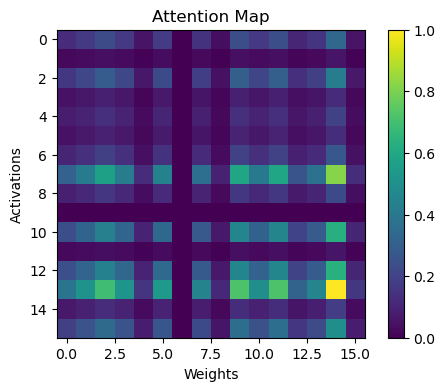

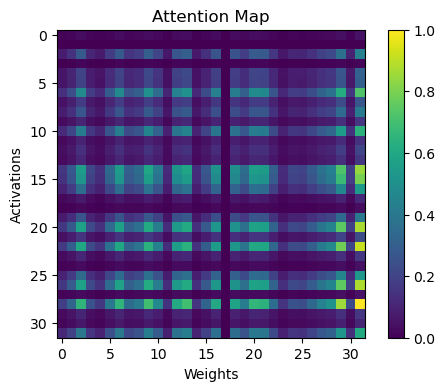

In [13]:
import ipdb
import matplotlib.pyplot as plt
for idx in range(len(mapped_layers['catcher']['name_list'])-1):
    curr_layer = eval(mapped_layers['catcher']['name_list'][idx])
    next_layer = eval(mapped_layers['catcher']['name_list'][idx+1])
    if((isinstance(curr_layer,nn.Conv2d)) and (isinstance(next_layer,nn.Conv2d))):
       
        y_i = mapped_layers['catcher']['y'][idx]
        w_j = mapped_layers['catcher']['w'][idx+1]
        n_y_i = get_importance(y_i).cpu()
        n_w_j = get_importance(w_j).cpu()

        n_y_i_min = torch.min(n_y_i)
        n_y_i_max = torch.max(n_y_i)
        n_y_i_normalized = (n_y_i - n_y_i_min) / (n_y_i_max - n_y_i_min)

        n_w_j_min = torch.min(n_w_j)
        n_w_j_max = torch.max(n_w_j)
        n_w_j_normalized = (n_w_j - n_w_j_min) / (n_w_j_max - n_w_j_min)

        attention_map = np.outer(n_y_i_normalized, n_w_j_normalized)
 
        plt.figure(figsize=(6, 4))
        plt.imshow(attention_map, cmap='viridis')
        plt.colorbar()

        plt.xlabel('Weights')
        plt.ylabel('Activations')
        plt.title('Attention Map')
        plt.show()
        # plt.plot(n_y_i_normalized, color='b')
        # plt.plot(n_w_j_normalized, color='g')
        # plt.show()
        # break

        

In [14]:
# Run Catcher : Done
# auto_scale_block
# apply_scale
# auto_clip_block 
# apply_clip

In [15]:
import copy
import torch

def pseudo_quantize_tensor(w, n_bit=8, zero_point=True, q_group_size=-1, inplace=False, get_scale_zp=False):
    org_w_shape = w.shape

    if len(org_w_shape) == 2:  # Handling 1D weights
        if q_group_size > 0:
            assert org_w_shape[-1] % q_group_size == 0
            w = w.reshape(-1, q_group_size)
            assert w.dim() == 2

        if zero_point:
            max_val = w.amax(dim=1, keepdim=True)
            min_val = w.amin(dim=1, keepdim=True)
            max_int = 2 ** n_bit - 1
            min_int = 0
            scales = (max_val - min_val).clamp(min=1e-5) / max_int
            zeros = (-torch.round(min_val / scales)).clamp_(min_int, max_int)
        else:
            max_val = w.abs().amax(dim=1, keepdim=True)
            max_val = max_val.clamp(min=1e-5)
            max_int = 2 ** (n_bit - 1) - 1
            min_int = -(2 ** (n_bit - 1))
            scales = max_val / max_int
            zeros = 0

        assert torch.isnan(scales).sum() == 0
        assert torch.isnan(w).sum() == 0

        if inplace:
            (((w.div_(scales).round_().add_(zeros)).clamp_(min_int, max_int).sub_(zeros)).mul_(scales))
        else:
            w = ((torch.clamp(torch.round(w / scales) + zeros, min_int, max_int) - zeros) * scales)

        assert torch.isnan(w).sum() == 0

    elif len(org_w_shape) == 4:  # Handling 2D convolutional weights
        if zero_point:
            max_val = w.amax(dim=(1, 2, 3), keepdim=True)
            min_val = w.amin(dim=(1, 2, 3), keepdim=True)
            max_int = 2 ** n_bit - 1
            min_int = 0
            scales = (max_val - min_val).clamp(min=1e-5) / max_int
            zeros = (-torch.round(min_val / scales)).clamp_(min_int, max_int)
        else:
            max_val = w.abs().amax(dim=(1, 2, 3), keepdim=True)
            max_val = max_val.clamp(min=1e-5)
            max_int = 2 ** (n_bit - 1) - 1
            min_int = -(2 ** (n_bit - 1))
            scales = max_val / max_int
            zeros = 0

        assert torch.isnan(scales).sum() == 0
        assert torch.isnan(w).sum() == 0

        if inplace:
            (((w.div_(scales).round_().add_(zeros)).clamp_(min_int, max_int).sub_(zeros)).mul_(scales))
        else:
            w = ((torch.clamp(torch.round(w / scales) + zeros, min_int, max_int) - zeros) * scales)

        assert torch.isnan(w).sum() == 0

    else:
        raise ValueError("Unsupported input shape")

    w = w.reshape(org_w_shape)

    if get_scale_zp:
        if len(org_w_shape) == 2:
            return w, scales.view(w.shape[0], -1), zeros.view(w.shape[0], -1)
        elif len(org_w_shape) == 4:
            return w, scales.view(w.shape[0], -1, 1, 1), zeros.view(w.shape[0], -1, 1, 1)
    else:
        return w


@torch.no_grad()
def get_act_scale(x):
   
    if(len(x.shape)==2):
        return x.abs().view(-1, x.shape[-1]).mean(0) 
    elif(len(x.shape)==4):
        return x.abs().view(-1, x.shape[1]).mean(0)

@torch.no_grad()
def _search_module_scale(x,w, module, y):
    # w: co, ci
    # x: n, ci

    x_max = get_act_scale(x)

    best_error = float("inf")
    best_ratio = -1
    best_scales = None

    n_grid = 20
    history = []
    best_ratio = -1
    sls = []
    org_sd = copy.deepcopy(module.state_dict())
    for ratio in range(n_grid):
        ratio = ratio * 1 / n_grid
        scales = x_max.pow(ratio).clamp(min=1e-4).view(-1)
        scales = scales / (scales.max() * scales.min()).sqrt()
        if(len(module.weight.shape)>2):
            module.weight.mul_(scales.view(1, -1,1,1).to(module.weight.device))
            module.weight.data = pseudo_quantize_tensor(w) / (scales.view(1, -1,1,1))
        else:
            module.weight.mul_(scales.view(1, -1).to(module.weight.device))
            module.weight.data = pseudo_quantize_tensor(w) / (scales.view(1, -1))
        out = module(x)
        if isinstance(out, tuple):
            out = out[0]

        loss = (
            (y - out).float().pow(2).mean().item()
        )  # float prevents overflow
        history.append(loss)
        sls.append(ratio)
        is_best = loss < best_error
        if is_best:
            best_error = loss
            best_ratio = ratio
            best_scales = scales
            # print(loss, ratio, scales)
        module.load_state_dict(org_sd)
    # if best_ratio == -1:
    # ipdb.set_trace()
    # plt.plot(sls, history)
        # raise Exception

    best_scales = best_scales.view(-1)

    assert torch.isnan(best_scales).sum() == 0, best_scales
    return best_scales.detach()

In [16]:
with torch.no_grad():
    for idx in range(1,len(conv_list)):
        
        
        x, w, y, module = mapped_layers['catcher']['x'][idx], mapped_layers['catcher']['w'][idx],mapped_layers['catcher']['y'][idx],eval(mapped_layers['catcher']['name_list'][idx])
        scales = _search_module_scale(x, w, module, y)
        module.weight.data.mul_(scales.view(1,-1,1,1))
    
        prev_w, prev_y, prev_module = mapped_layers['catcher']['w'][idx-1], mapped_layers['catcher']['y'][idx-1],eval(mapped_layers['catcher']['name_list'][idx-1])
        prev_module.weight.data.div_(scales.view(-1,1,1,1))
        mapped_layers['catcher']['w'][idx] = prev_module.weight.data
        mapped_layers['catcher']['x'][idx].div_(scales.view(1,-1,1,1))
        mapped_layers['catcher']['y'][idx] = mapped_layers['catcher']['x'][idx]
  

